<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/project123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
zip_path = '/content/drive/MyDrive/363PROJECT/BrainTumorDataset.zip'
import shutil

# مسار لفك الضغط
extract_path = '/content/drive/MyDrive/363PROJECT'

# فك الضغط
shutil.unpack_archive(zip_path, extract_path)

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [16]:
# دالة لتحميل الصور والأقنعة
def load_data(main_dir, img_size=(128, 128)):
    images, masks = [], []
    classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}  # تصنيفات الفئات
    for category in classes.keys():
        category_path = os.path.join(main_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # قراءة الصورة
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)

            # إنشاء القناع
            mask = classes[category]
            masks.append(mask)

    images = np.array(images) / 255.0  # تطبيع الصور
    images = np.expand_dims(images, axis=-1)  # إضافة بُعد القناة
    masks = np.array(masks)  # تحويل الأقنعة إلى مصفوفة
    return images, masks

# مسارات المجلدات
training_dir = '/content/drive/MyDrive/363PROJECT/Training'
testing_dir = '/content/drive/MyDrive/363PROJECT/Testing'


# تحميل بيانات التدريب والاختبار
X_train, y_train = load_data(training_dir)
X_test, y_test = load_data(testing_dir)

# التأكد من الأشكال
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5712, 128, 128, 1)
y_train shape: (5712,)
X_test shape: (1311, 128, 128, 1)
y_test shape: (1311,)


In [38]:
# تحويل الأقنعة إلى One-Hot Encoding
from tensorflow.keras.utils import to_categorical

# إعادة تشكيل الأقنعة لتكون بكسلية (Pixel-wise Masks)
y_train_encoded = np.argmax(y_train, axis=-1)
y_train = to_categorical(y_train_encoded, num_classes=4)

y_test_encoded = np.argmax(y_test, axis=-1)
y_test = to_categorical(y_test_encoded, num_classes=4)

# التأكد من الأبعاد الجديدة
print("y_train new shape:", y_train.shape)
print("y_test new shape:", y_test.shape)


y_train new shape: (5712, 128, 128, 4)
y_test new shape: (1311, 128, 128, 4)


In [39]:
print("Original y_train shape:", y_train.shape)


Original y_train shape: (5712, 128, 128, 4)


In [40]:
# تحويل y_train و y_test إلى أقنعة لكل بكسل
def create_pixel_masks(y, img_size=(128, 128), num_classes=4):
    masks = []
    for label in y:
        # إنشاء قناع لكل تصنيف بحجم الصورة
        mask = np.full((img_size[0], img_size[1], num_classes), label.argmax(), dtype=np.float32)
        masks.append(mask)
    return np.array(masks)

# إنشاء أقنعة بكسلية
y_train = create_pixel_masks(y_train, img_size=(128, 128), num_classes=4)
y_test = create_pixel_masks(y_test, img_size=(128, 128), num_classes=4)

# التأكد من الأشكال
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5712, 128, 128, 1)
y_train shape: (5712, 128, 128, 4)
X_test shape: (1311, 128, 128, 1)
y_test shape: (1311, 128, 128, 4)


In [51]:
def unet_model(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs, outputs)
    #model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 128, 128, 4)         │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,756 (2.82 MB)

 Trainable params: 738,756 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
print("X_train min, max:", X_train.min(), X_train.max())
print("y_train min, max:", y_train.min(), y_train.max())


X_train min, max: 0.0 1.0
y_train min, max: 0.0 0.0


In [54]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=16
)




Epoch 1/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.1451 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
643/643 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

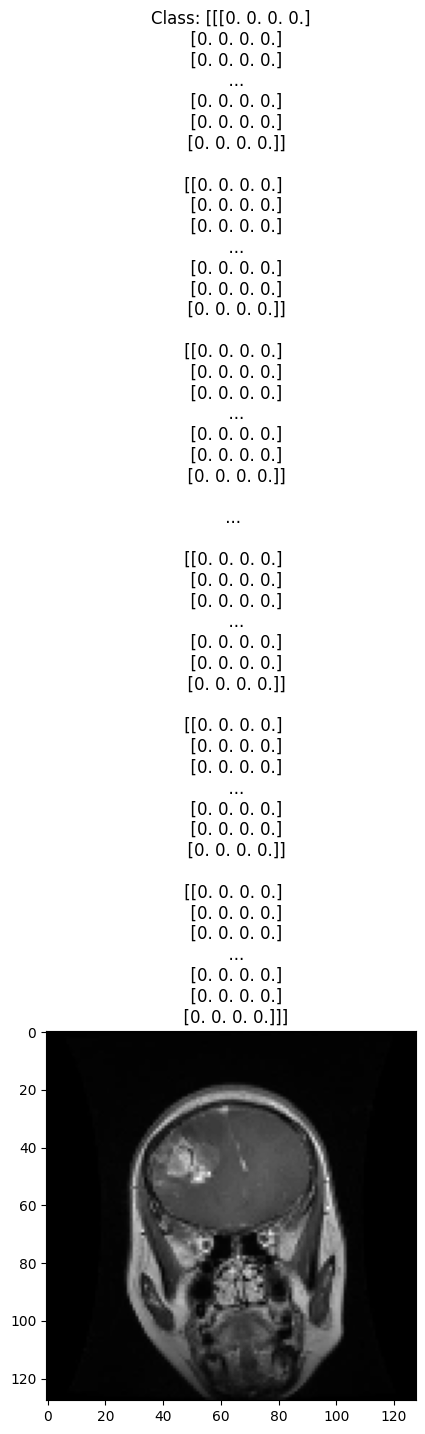

In [32]:
# عرض صورة من بيانات التدريب
plt.imshow(X_train[0][:, :, 0], cmap='gray')
plt.title(f"Class: {y_train[0]}")
plt.show()

In [28]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 4)         │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,756 (2.82 MB)

 Trainable params: 738,756 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


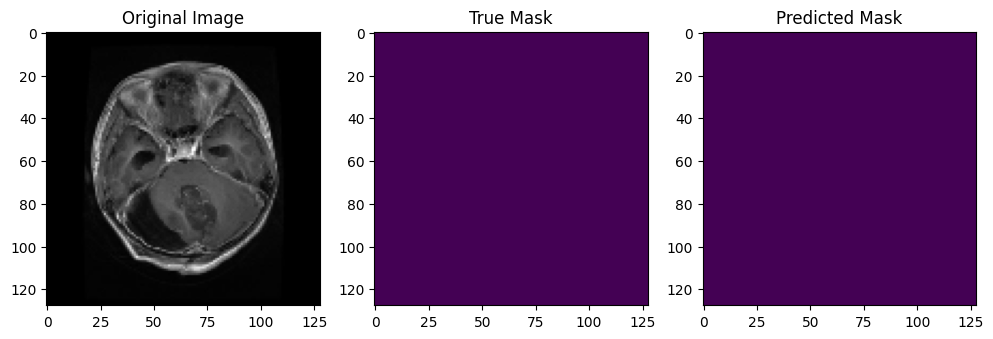

In [33]:
def display_results(image, mask_true, mask_pred):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(np.argmax(mask_true, axis=-1), cmap='viridis')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(np.argmax(mask_pred, axis=-1), cmap='viridis')

    plt.show()

# التنبؤ على صورة اختبارية
predicted_mask = model.predict(np.expand_dims(X_test[0], axis=0))
display_results(X_test[0], y_test[0], predicted_mask[0])
